In [1]:
# Memeriksa Instalasi tensorFlow
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [2]:
# Menginstal TensorFlow (jika tidak Ada)
!pip install tensorflow

Preprocessing

In [3]:
# Mingimpor Pustaka
from google.colab import drive

import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import zipfile
import matplotlib.pyplot as plt

Memuat Data

In [4]:
# Mengatur lokasi path file yang dipakai di google drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/Shareddrives')

Mounted at /content/drive


In [5]:
# Menyimpan lokasi direktori dataset di Google Drive
dataset_path = '/content/drive/Shareddrives/BANGKIT/garbage_classification'

In [6]:
# Memuat dataset gambar 'sampah' dari google drive
# Membagi dataset gambar 'sampah' menjadi data training dan validasi
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # memisahkan 20% data untuk validasi
    subset="training",
    seed=123,
    image_size=(128, 128), # menetapkan ukuran gambar yang konsisten
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # memisahkan 20% data untuk validasi
    subset="validation",
    seed=123,
    image_size=(128, 128), # menetapkan ukuran gambar yang konsisten
    batch_size=32
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


Normalisasi Data

In [7]:
# menghindari nilai piksel yang besar
normalization_layer = layers.Rescaling(1./255)

Augmentasi Data

In [8]:
# Melakukan augmentasi data pada dataset training
# Menerapkan normalisasi pada dataset training dan validasi.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),

])

train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Optimasi dengan Prefetching, caching, shuffling

In [9]:
# Meningkatkan efisiensi pemrosesan data menggunakan caching, shuffling, dan prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds.take(1):
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", labels_batch.shape)

Image batch shape:  (32, 128, 128, 3)
Label batch shape:  (32,)


Visualisasi Data

Run kembali untuk melihat output yang lain

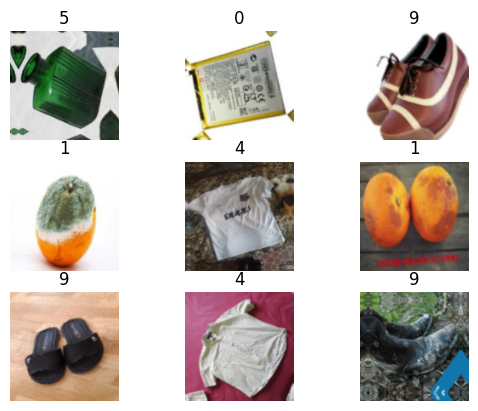

In [10]:
# Menampilkan contoh gambar dari batch data training
for image_batch, label_batch in train_ds.take(1):
  plt.figure(figure=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    plt.title(int(label_batch[i]))
    plt.axis("off")
  plt.show()

# Model

In [11]:
# Menampilkan jumlah GPU yang tersedia
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Path ke dataset
dataset_path = "/content/drive/Shareddrives/BANGKIT/garbage_classification"  # Ganti dengan path yang sesuai

# Inisialisasi Dataset Training dan Validasi
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Menentukan Jumlah Kelas
num_classes = len(train_ds.class_names)

# Mendefinisikan Model CNN
def create_model():
    # Memuat ResNet50 sebagai base model
    base_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Membekukan base model untuk transfer learning awal

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Mencompile model
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Menampilkan model
model = create_model()

# Aktifkan fine-tuning setelah memastikan arsitektur model
base_model = model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile model setelah perubahan pada base_model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Menentukan Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

# Menentukan Parameter Pelatihan
num_train_samples = 12412
num_val_samples = 3103

batch_size = 32
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size

train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

# Melatih model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=callbacks
)

Num GPUs Available:  1
Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.3785 - loss: 2.1077 - val_accuracy: 0.7799 - val_loss: 0.7543 - learning_rate: 1.0000e-04
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 66s 153ms/step - accuracy: 0.7464 - loss: 0.8209 - val_accuracy: 0.8346 - val_loss: 0.5494 - learning_rate: 1.0000e-04
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 57s 148ms/step - accuracy: 0.8228 - loss: 0.5658 - val_accuracy: 0.8574 - val_loss: 0.4699 - learning_rate: 1.0000e-04
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 57s 147ms/step - accuracy: 0.8532 - loss: 0.4725 - val_accuracy: 0.8759 - val_loss: 0.4131 - learning_rate: 1.0000e-04
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 59s 151ms/step - accuracy: 0.8811 - loss: 0.3903 - val_accuracy: 0.8906 - val_loss: 0.3757 - learning

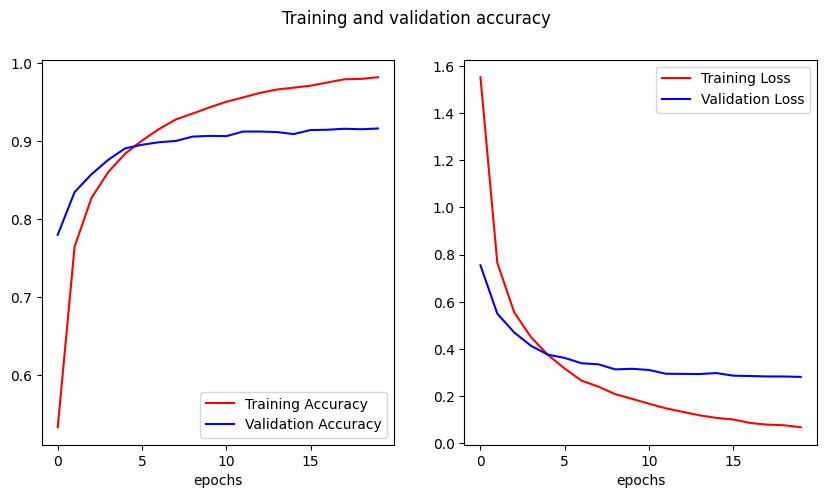

In [12]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

Compile Model

In [13]:
# model = create_model()

# # Menentukan Mixed Precision
# from tensorflow.keras import mixed_precision
# policy = mixed_precision.Policy('float32')
# mixed_precision.set_global_policy(policy)

# # Menentukan Callback
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint('/content/best_model.keras', save_best_only=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e76)
# ]

# # Menentukan Parameter Pelatihan
# num_train_samples = 12412
# num_val_samples = 3103

# batch_size = 32
# steps_per_epoch = num_train_samples // batch_size
# validation_steps = num_val_samples // batch_size

# train_ds = train_ds.repeat()
# val_ds = val_ds.repeat()

# # Melatih model
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     epochs=20,
#     callbacks=callbacks
# )


In [14]:
# Cetak Akurasi Model
test_loss, test_acc = model.evaluate(val_ds, steps=1000)
print(f"Test accuracy: {test_acc}")


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 113s 113ms/step - accuracy: 0.9149 - loss: 0.2829
Test accuracy: 0.9165051579475403


In [15]:
# Menyimpan struktur model dalam format JSON
model_json = model.to_json()
with open("/content/model_structure.json", "w") as json_file:
    json_file.write(model_json)

# Menyimpan bobot model dalam format HDF5
model.save_weights("/content/model_weights.weights.h5")
print("Model structure and weights saved to disk in /content.")


Model structure and weights saved to disk in /content.


In [16]:
from google.colab import files

# Mendownload file struktur model
files.download("/content/model_structure.json")

# Mendownload file bobot model
files.download("/content/model_weights.weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>